# Import libraries

In [1]:
import numpy as np
import uproot as up
import awkward as ak
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
import pandas as pd
import mplhep as hep
hep.style.use("CMS")

# Load data

In [208]:
class Jet:
    
    def __init__(self, path, branch="outnano/Jets"):
        self.file = up.open(path)[branch]
        
    @staticmethod
    def load(file, vars_to_load = ["pt", "eta_phys", "mass", "genmatch_pt", "genmatch_eta", "genmatch_mass"]):
        data = file.arrays( filter_name = [f"jet_{var}" for var in vars_to_load]+["event"] )
        reject_mask = file["jet_reject"].array() == False
        return data[reject_mask]

    @staticmethod
    def filter_unmatched(data):
        genmatch_mask = (data["jet_genmatch_pt"] > 0) & (data["jet_genmatch_mass"] > 0)
        return data[genmatch_mask]

    @staticmethod
    def l1cuts(data, ptcut = 0, etacut = 5.0, masscut = 0):
        cuts_mask = (data["jet_pt"] > ptcut) & (np.abs(data["jet_eta_phys"]) < etacut) & (data["jet_mass"] > masscut)
        return data[cuts_mask]
    
    @staticmethod
    def preprocess(data):
        mask = (data["jet_genmatch_mass"] > 0) & (data["jet_genmatch_mass"] < 182)
        # mask = mask & ( (data["jet_genmatch_pt"] > 0) & (data["jet_genmatch_pt"] < 500) )
        # data = data[mask]
        # data["jet_pt"] = np.clip(a = data["jet_pt"], a_min=0, a_max = 500)
        return data[mask]
    
    @staticmethod
    def shuffle(data):
        shuffle = np.random.permutation(len(data))
        return data[shuffle]
    
    @staticmethod
    def split(data, train_ratio = 0.7):
        splitIdx = int(len(data) * train_ratio)
        data_train, data_test = data[:splitIdx], data[splitIdx:]
        return data_train, data_test
    
    @staticmethod
    def response(data_train, eps = 1e-6):
        pt_response = (data_train["jet_pt"] + eps) / (data_train["jet_genmatch_pt"] + eps)
        mass_response = (data_train["jet_mass"] + eps) / (data_train["jet_genmatch_mass"] + eps)
        data_train["pt_response"] = pt_response
        data_train["mass_response"] = mass_response
        return data_train, pt_response, mass_response
    
    @staticmethod
    def histogram(
        data_train: ak.highlevel.Array, nBins: int = 101, nan: int = 1, how: str = "mean"
        ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

        l1_vars = ["jet_pt", "jet_eta_phys", "jet_mass"]
        bins = [nBins] * 3

        train_numpy = np.column_stack( [ ak.to_numpy(data_train[l1_var]) for l1_var in l1_vars ] )    # convert to numpy for scipy binned stats dd
        pt_resp, _, _ = binned_statistic_dd( train_numpy, ak.to_numpy(data_train["pt_response"]), statistic = how, bins = bins )
        mass_resp, edges, _ = binned_statistic_dd( train_numpy, ak.to_numpy(data_train["mass_response"]), statistic = how, bins = bins )
        
        pt_sf = 1 / np.nan_to_num(pt_resp, nan=nan)
        mass_sf = 1 / np.nan_to_num(mass_resp, nan=nan)
        return pt_sf, mass_sf, pt_resp, mass_resp, edges
    
    @staticmethod
    def apply_scale_factors(data_test, bin_edges, pt_scalefactors, mass_scalefactors):
        l1_vars = ["jet_pt", "jet_eta_phys", "jet_mass"]

        bin_idx = [ np.digitize(data_test[l1_vars[i]], bin_edges[i]) - 1 for i in range(3) ]
        bin_idx = ak.to_numpy( np.stack(bin_idx, axis=-1) )

        # check that jet falls into a valid, predefined bin
        valid = np.all( [(0 <= bin_idx[:, i]) & (bin_idx[:, i] < len(bin_edges[i]) - 1) for i in range(3)], axis=0 )

        # initialize output and assign values from mean_values
        pt_output, mass_output = np.ones( len(data_test) ), np.ones( len(data_test) )
        pt_output[valid] = pt_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        mass_output[valid] = mass_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        
        pt_corr, mass_corr = data_test["jet_pt"] * pt_output, data_test["jet_mass"] * mass_output
        data_test["jet_pt_corr"], data_test["jet_mass_corr"] = pt_corr, mass_corr
        return data_test, pt_corr, mass_corr

    @staticmethod
    def to_dataframe(data):
        return ak.to_dataframe(data)
        
    def pipeline(self):

        print("Loading data...")
        data = self.load(file = self.file)
        print("Data loaded!\n")

        print("Filtering out unmatched jets...")
        data = self.filter_unmatched(data)
        print(f"Removed unmatched jets!\n")

        print("Applying level-1 cuts...")
        data = self.l1cuts(data)
        print("Level-1 cuts applied!\n")
        
        print("Preprocessing data...")
        data = self.preprocess(data)
        print("Data preprocessed!\n")

        print("Shuffling jets...")
        data = self.shuffle(data)
        print("Jets shuffled!\n")

        print("Splitting jets into test and train...")
        train, test = self.split(data)
        print("Jets split into test and train!\n")

        print("Calculating response of each jet from training data...")
        train, pt_response, mass_response = self.response(train, eps=1e-6)
        print("Responses calculated!\n")

        print("Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...")
        pt_sf, mass_sf, pt_resp, mass_resp, edges = self.histogram(train, nBins=101, nan=1, how="mean")
        print("Scale factors calculated!\n")

        print("Applying derived scale factors to test jets...")
        test, pt_corr, mass_corr = self.apply_scale_factors(test, edges, pt_sf, mass_sf)
        print("Scale factors applied to test jets!")

        return test

In [218]:
def binResp(arr, var):
    if var == "pt":
        gen = arr["jet_genmatch_pt"]
        reco_resp, corr_resp = arr["jet_pt"] / gen, arr["jet_pt_corr"] / gen
        bins = np.linspace(0, 500, 101)
    elif var == "mass":
        gen = arr["jet_genmatch_mass"]
        reco_resp, corr_resp = arr["jet_mass"] / gen, arr["jet_mass_corr"] / gen
        bins = np.linspace(0, 180, 101)
    else:
        raise Exception("Invalid variable!")

    reco_mean, reco_stddev = [], []
    corr_mean, corr_stddev = [], []
    for b in range( len(bins) - 1 ):
        mask = (gen >= bins[b]) & (gen < bins[b+1])
        recoInBin, corrInBin = reco_resp[mask], corr_resp[mask]

        reco_mean.append( np.mean(recoInBin) )
        reco_stddev.append( np.var(recoInBin, ddof=1) )

        corr_mean.append( np.mean(corrInBin) )
        corr_stddev.append( np.var(corrInBin, ddof=1) )

    return reco_mean, reco_stddev, corr_mean, corr_stddev, bins


def plotResp(arr, var = ["pt", "mass"]):
    _, axes = plt.subplots(2, max(len(var),2), figsize=(21.60, 14.4))
    for i, v in enumerate(var):
        mean_ax, std_ax = axes[i]
        reco_mean, reco_stddev, corr_mean, corr_stddev, bins = binResp(arr, v)
        xs = ((bins/2)[1] + bins)[:-1]

        std_ax.errorbar(xs, reco_stddev, label=f"Reco {v}", fmt="-", capsize=5)
        std_ax.errorbar(xs, corr_stddev, label=f"Corr {v}", fmt="-", capsize=5)
        std_ax.set_xlabel(f"{v}"+"$_{gen} (GeV)$", fontsize=20); std_ax.set_ylabel("$\sigma^2( \\frac{L1}{Gen} )$", fontsize=20)

        mean_ax.errorbar(xs, reco_mean, label=f"Reco {v}", fmt="-", capsize=5)    # plot reco bias
        mean_ax.errorbar(xs, corr_mean, label=f"Corr {v}", fmt="-", capsize=5)    # plot corr bias
        mean_ax.set_xlabel(f"{v}"+"$_{gen}$ (GeV)", fontsize=20); mean_ax.set_ylabel("$\mu( \\frac{L1}{Gen} )$", fontsize=20)

        std_ax.axhline(0, color="black", linestyle="--", label="Pefect variance")
        std_ax.set_xlim([bins[0], bins[-1]]); std_ax.set_ylim([-0.05, 1.05])
        std_ax.set_xticks(bins[::10]); std_ax.set_yticks(np.linspace(-0, 1, 11))
        std_ax.grid()
        std_ax.legend()
        hep.cms.label(ax=std_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)
        
        mean_ax.axhline(1, color="black", linestyle="--", label="Perfect bias")
        mean_ax.set_xlim([bins[0], bins[-1]]); mean_ax.set_ylim([0,2])
        mean_ax.set_xticks(bins[::10]); mean_ax.set_yticks(np.linspace(0,2,11))
        mean_ax.grid()
        mean_ax.legend()
        hep.cms.label(ax=mean_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)

    plt.tight_layout()
    plt.show()

In [210]:
path = "./data/sc8Jets.root"
jets = Jet(path)

In [211]:
arr = jets.pipeline()

Loading data...
Data loaded!

Filtering out unmatched jets...
Removed unmatched jets!

Applying level-1 cuts...
Level-1 cuts applied!

Preprocessing data...
Data preprocessed!

Shuffling jets...
Jets shuffled!

Splitting jets into test and train...
Jets split into test and train!

Calculating response of each jet from training data...
Responses calculated!

Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...
Scale factors calculated!

Applying derived scale factors to test jets...
Scale factors applied to test jets!


In [216]:
ak.to_dataframe(arr)

,event,jet_eta_phys,jet_pt,jet_mass,jet_genmatch_pt,jet_genmatch_eta,jet_genmatch_mass,jet_pt_corr,jet_mass_corr
entry,,,,,,,,,
0,277590,1.243291,33.25,14.044572,56.963840,1.158316,28.103212,34.778090,14.902060
1,239947,-2.085447,32.25,6.000000,36.464260,-2.172296,15.515990,27.519811,7.738349
2,252720,0.645806,15.50,0.866025,34.944214,0.669999,11.803365,21.542821,0.252345
3,316499,0.013039,286.75,79.018982,237.584518,-0.015848,78.676216,284.933881,81.179449
4,489880,2.116127,296.00,10.908712,304.609772,2.138946,52.854240,311.380445,37.112342
...,...,...,...,...,...,...,...,...,...
1719119,74458,0.091272,90.50,26.186829,133.030151,-0.042209,58.461456,90.467839,30.339111
1719120,332985,0.335942,75.75,16.393597,54.034164,0.414737,10.712012,84.236471,21.446691
1719121,420364,1.020864,150.25,31.784430,147.408142,1.080973,44.298859,160.622684,34.610873


# Produce response plots

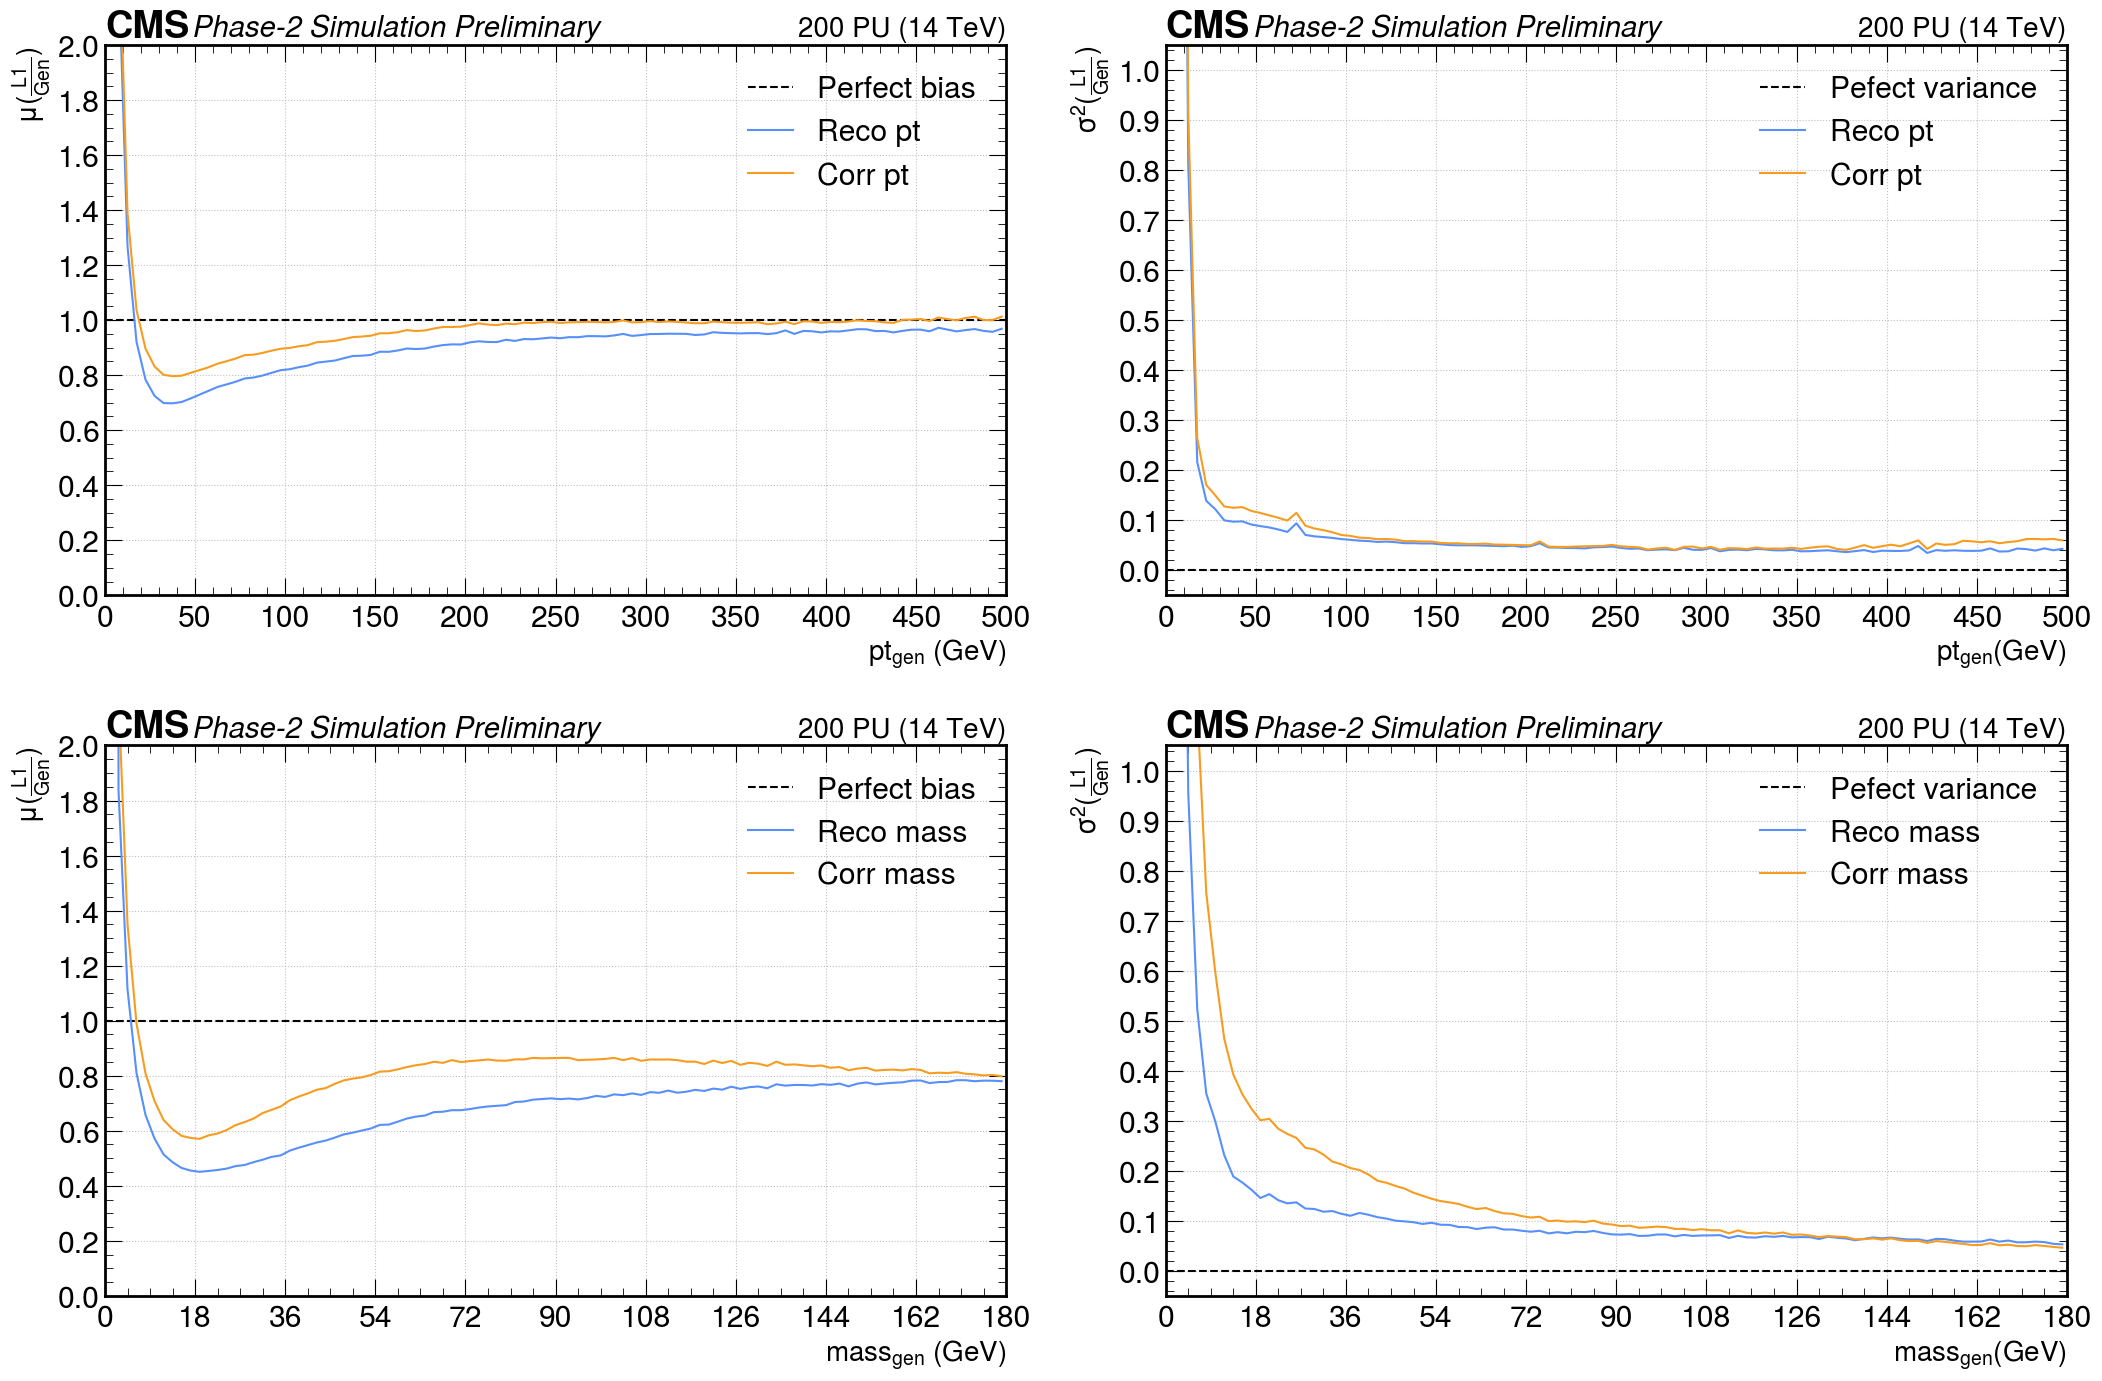

In [219]:
plotResp(ak.to_dataframe(arr))

# Test performance after applying corrections

In [ ]:
tt_path = "./data/TT_PU200.root"
tt = up.open(tt_path + ":outnano/Jets").arrays(filter_name=["event", "jet_pt", "jet_eta", "jet_mass"])

In [ ]:
tt_jets = Jet(tt_path, "pt", "eta_phys")

In [10]:
tt_jets.load()

Loading L1 data with pt == pt and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 3663 jets marked as bad.
Total jets = 1633834




(array([[ 5.9500000e+01,  1.0868254e+00,  5.0744457e+00],
        [ 5.5500000e+01,  1.4572818e+00,  1.9435791e+01],
        [ 4.5500000e+01,  2.1475732e-02,  6.4807405e+00],
        ...,
        [ 8.2250000e+01, -6.0208750e-01,  1.1180340e+00],
        [ 6.8250000e+01,  2.1030877e+00,  1.8708287e+00],
        [ 1.3000000e+01,  4.6709716e-01,  4.0000000e+00]], dtype=float32),
 array([[ 7.48984070e+01,  1.08570123e+00,  1.88406544e+01,
          1.23007000e+05],
        [ 1.04394257e+02,  1.39611602e+00,  2.89913616e+01,
          1.23007000e+05],
        [ 5.95109749e+01,  8.65622610e-02,  1.63642693e+01,
          1.23007000e+05],
        ...,
        [ 8.25055008e+01, -6.09568655e-01,  1.62085571e+01,
          2.51998000e+05],
        [ 9.25609512e+01,  2.14248943e+00,  1.94703541e+01,
          2.51998000e+05],
        [ 2.93079987e+01,  5.06227791e-01,  1.16099844e+01,
          2.51998000e+05]]))

In [11]:
tt_jets

In [ ]:
# groupby event
sorted_arr = tt[ak.argsort(tt.event)]
counts = ak.run_lengths(sorted_arr.event)
tt_grouped = ak.unflatten(sorted_arr, counts)

In [ ]:
def applyScaleFactors_awkward(jets, bin_edges, pt_sf, mass_sf):
    """
    jets: awkward array with fields jet_pt, jet_eta, jet_mass
    bin_edges: list/tuple of 3 arrays [pt_edges, eta_edges, mass_edges]
    pt_sf, mass_sf: 3D numpy arrays of scale factors with shape
                    (n_pt_bins, n_eta_bins, n_mass_bins)
    """

    # ---- STEP 1: Extract numpy views of the awkward fields ----
    pt   = ak.to_numpy(jets["jet_pt"])
    eta  = ak.to_numpy(jets["jet_eta"])
    mass = ak.to_numpy(jets["jet_mass"])

    # ---- STEP 2: Find bin indices along each axis ----
    # np.digitize returns indices 1..N, so subtract 1 for 0-based indexing
    pt_idx   = np.digitize(pt,   bin_edges[0]) - 1
    eta_idx  = np.digitize(eta,  bin_edges[1]) - 1
    mass_idx = np.digitize(mass, bin_edges[2]) - 1

    bin_idx = np.stack([pt_idx, eta_idx, mass_idx], axis=-1)

    # ---- STEP 3: Validity mask: jet must be inside all defined bins ----
    valid = (
        (bin_idx[:,0] >= 0) & (bin_idx[:,0] < len(bin_edges[0]) - 1) &
        (bin_idx[:,1] >= 0) & (bin_idx[:,1] < len(bin_edges[1]) - 1) &
        (bin_idx[:,2] >= 0) & (bin_idx[:,2] < len(bin_edges[2]) - 1)
    )

    # ---- STEP 4: Allocate outputs ----
    pt_output   = np.ones(len(pt))
    mass_output = np.ones(len(pt))

    # ---- STEP 5: Fill valid bins with scale factors ----
    pt_output[valid] = pt_sf   [bin_idx[valid,0], bin_idx[valid,1], bin_idx[valid,2]]
    mass_output[valid] = mass_sf[bin_idx[valid,0], bin_idx[valid,1], bin_idx[valid,2]]

    # ---- STEP 6: Apply corrections ----
    pt_corr   = pt   * pt_output
    mass_corr = mass * mass_output

    # ---- STEP 7: Append corrected values as new fields ----
    jets = jets.assign(
        pt_corr   = pt_corr,
        mass_corr = mass_corr,
        pt_sf     = pt_output,
        mass_sf   = mass_output,
        valid_bin = valid
    )

    return jets


In [14]:
applyScaleFactors_awkward(tt, )

TypeError: applyScaleFactors_awkward() missing 3 required positional arguments: 'bin_edges', 'pt_sf', and 'mass_sf'

In [ ]:
# gen_mass = pt_df.gen_mass
mass_resp = (pt_df.reco_mass+10.33) / pt_df.gen_mass
mass_resp_corr = (pt_df.corr_mass+10.33) / pt_df.gen_mass



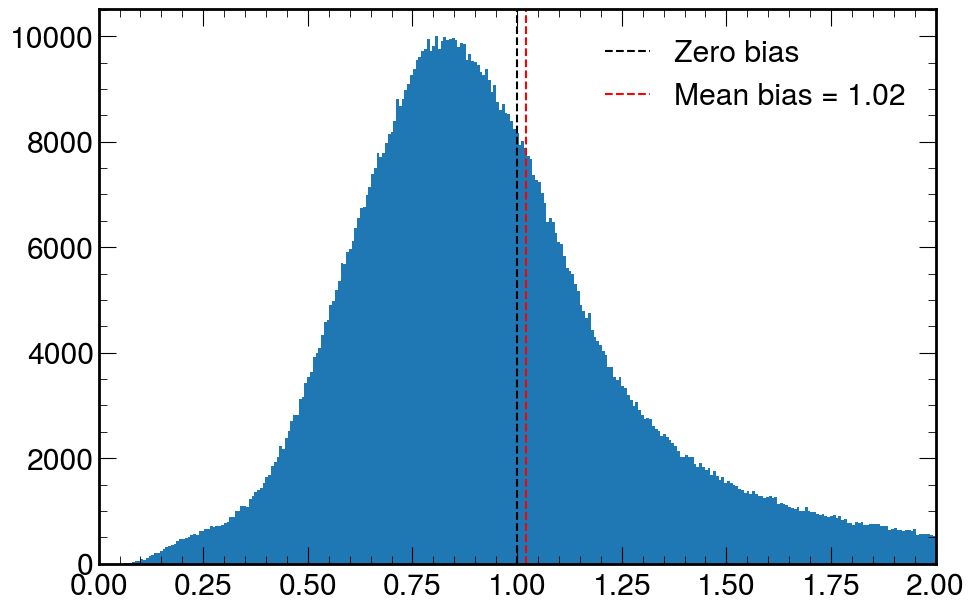

In [ ]:
plt.figure(figsize=(10.8, 7.2))
plt.hist(mass_resp, bins=301, range=[0,2])

plt.axvline(1, color="black", linestyle="--", label="Zero bias")
plt.axvline(np.mean(mass_resp), color="red", linestyle="--", label=f"Mean bias = {np.mean(mass_resp):.2f}")
# plt.axvline(np.median(mass_resp), color="orange", linestyle="-.", label=f"Median bias = {np.mean(mass_resp):.2f}")

plt.legend()
plt.xlim([0,2])
plt.show()